In [1]:
import os
import re
import urllib.request
from collections import Counter
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from konlpy.tag import Okt
from konlpy.tag import Mecab
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from utils import *
%matplotlib inline

In [2]:
train_data, test_data = get_data()

In [3]:
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

## 2) 데이터로더 구성
---
imdb.data_loader()와 동일하게 동작하는 나만의 data_loader를 만들어보자  
- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords)제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

### 3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [5]:
X_train, X_test = get_train_test(X_train, X_test, word_to_index)

문장길이 평균 :  15.79866194196276
문장길이 최대 :  116
문장길이 표준편차 :  12.666606298507723
pad_sequences maxlen :  34
전체 문장의 0.9079640448208398%가 maxlen 설정값 이내에 포함됩니다. 


### 4) 모델구성 및 Validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.  
#### 4-1 validation set 구성

In [6]:
partial_X_train, partial_y_train, X_val, y_val = set_validation(X_train, y_train, n = 50000)

(50000, 34) (50000,)
(96182, 34) (96182,)


#### 4-2 model 구성
1. LSTM

In [7]:
lstm = model(model_name='lstm', vocab_size=10000, word_vector_dim=32)

2. cnn

In [8]:
cnn = model(model_name='cnn', vocab_size=10000, word_vector_dim=32)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1552      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                

3. GlobalMaxPooling

In [9]:
gmp = model(model_name='gmp', vocab_size=10000, word_vector_dim=32)

### 5) 모델 훈련 개시
---

1. LSTM train

Epoch 1/30
188/188 [==============================] - 12s 62ms/step - loss: 0.5670 - accuracy: 0.7601 - val_loss: 0.4274 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 11s 61ms/step - loss: 0.4051 - accuracy: 0.8357 - val_loss: 0.3692 - val_accuracy: 0.8466 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 11s 60ms/step - loss: 0.3618 - accuracy: 0.8514 - val_loss: 0.3558 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 12s 61ms/step - loss: 0.3389 - accuracy: 0.8625 - val_loss: 0.3543 - val_accuracy: 0.8497 - lr: 9.0484e-04
Epoch 5/30
188/188 [==============================] - 11s 61ms/step - loss: 0.3255 - accuracy: 0.8683 - val_loss: 0.3518 - val_accuracy: 0.8512 - lr: 8.1873e-04
Epoch 6/30
188/188 [==============================] - 11s 61ms/step - loss: 0.3175 - accuracy: 0.8717 - val_loss: 0.3532 - val_accuracy: 0.8506 - lr: 7.4082e-04
Epoch 7/30
188/188 [==========================

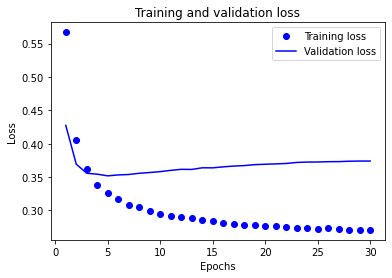

In [10]:
lstm_history = train_model(partial_X_train, partial_y_train, X_val, y_val, lstm,lr=0.001, epochs = 30
                           , batch_size = 512,
                plot_graph=True)

2. model 저장

In [17]:
!mkdir -p saved_lstm

In [ ]:
lstm.save('saved_lstm/lstm_model')

In [ ]:
new_model = tf.keras.models.load_model('saved_lstm/lstm_model')

In [11]:
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)

1537/1537 - 12s - loss: 0.3881 - accuracy: 0.8417


2. cnn

Epoch 1/15
188/188 [==============================] - 9s 46ms/step - loss: 0.5209 - accuracy: 0.7331 - val_loss: 0.3675 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 2/15
188/188 [==============================] - 1s 5ms/step - loss: 0.3335 - accuracy: 0.8566 - val_loss: 0.3456 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/15
188/188 [==============================] - 1s 5ms/step - loss: 0.2913 - accuracy: 0.8781 - val_loss: 0.3476 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/15
188/188 [==============================] - 1s 5ms/step - loss: 0.2589 - accuracy: 0.8946 - val_loss: 0.3556 - val_accuracy: 0.8483 - lr: 9.0484e-04
Epoch 5/15
188/188 [==============================] - 1s 5ms/step - loss: 0.2300 - accuracy: 0.9097 - val_loss: 0.3742 - val_accuracy: 0.8458 - lr: 8.1873e-04
Epoch 6/15
188/188 [==============================] - 1s 5ms/step - loss: 0.2034 - accuracy: 0.9227 - val_loss: 0.3919 - val_accuracy: 0.8444 - lr: 7.4082e-04
Epoch 7/15
188/188 [==============================] - 1s 

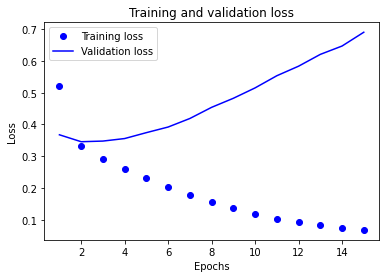

In [13]:
cnn_history = train_model(partial_X_train, partial_y_train, X_val, y_val, cnn,lr=0.001, epochs = 15, batch_size = 512,
                plot_graph=True)

In [17]:
!mkdir -p saved_cnn
cnn.save('saved_cnn/cnn_model')
new_cnn = tf.keras.models.load_model('saved_cnn/cnn_model')
loss, acc = new_cnn.evaluate(X_test, y_test, verbose=2)

INFO:tensorflow:Assets written to: saved_cnn/cnn_model/assets
1537/1537 - 4s - loss: 0.6995 - accuracy: 0.8267


3. GlobalMaxPooling

Epoch 1/15
188/188 [==============================] - 1s 4ms/step - loss: 0.5824 - accuracy: 0.7619 - val_loss: 0.4306 - val_accuracy: 0.8211 - lr: 0.0010
Epoch 2/15
188/188 [==============================] - 1s 4ms/step - loss: 0.3736 - accuracy: 0.8425 - val_loss: 0.3597 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 3/15
188/188 [==============================] - 1s 4ms/step - loss: 0.3167 - accuracy: 0.8679 - val_loss: 0.3495 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 4/15
188/188 [==============================] - 1s 4ms/step - loss: 0.2831 - accuracy: 0.8836 - val_loss: 0.3505 - val_accuracy: 0.8486 - lr: 9.0484e-04
Epoch 5/15
188/188 [==============================] - 1s 4ms/step - loss: 0.2578 - accuracy: 0.8966 - val_loss: 0.3555 - val_accuracy: 0.8482 - lr: 8.1873e-04
Epoch 6/15
188/188 [==============================] - 1s 4ms/step - loss: 0.2372 - accuracy: 0.9068 - val_loss: 0.3625 - val_accuracy: 0.8483 - lr: 7.4082e-04
Epoch 7/15
188/188 [==============================] - 1s 4

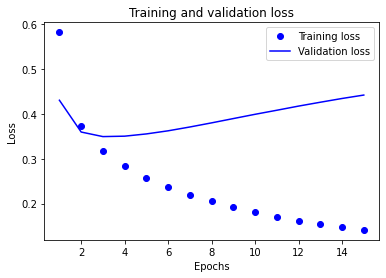

In [16]:
gmp_history = train_model(partial_X_train, partial_y_train, X_val, y_val, gmp,lr=0.001, epochs = 15, batch_size = 512,
                plot_graph=True)

In [18]:
!mkdir -p saved_gmp
gmp.save('saved_gmp/gmp_model')
new_gmp = tf.keras.models.load_model('saved_gmp/gmp_model')
loss, acc = new_gmp.evaluate(X_test, y_test, verbose=2)

INFO:tensorflow:Assets written to: saved_gmp/gmp_model/assets
1537/1537 - 1s - loss: 0.4552 - accuracy: 0.8363


### 7) 학습된 Embedding 레이어 분석

In [19]:
save_embedding_vector(lstm, index_to_word,vocab_size = 10000, word_vector_dim = 32, file_name='word2vec_lstm.txt')
save_embedding_vector(cnn, index_to_word,vocab_size = 10000, word_vector_dim = 32, file_name='word2vec_cnn.txt')
save_embedding_vector(gmp, index_to_word,vocab_size = 10000, word_vector_dim = 32, file_name='word2vec_gmp.txt')

1. LSTM

In [25]:
evaluate_embedding_layer(file_name='word2vec_lstm.txt', word='강추')

vector.shape : 
 (32,)
vector : 
 [ 0.01789022 -0.04064023 -0.01212628 -0.03138744 -0.0233745   0.02798187
  0.03132708  0.04321598  0.03436532  0.00274823 -0.0412307   0.01708053
  0.04366418 -0.0447032   0.02849236 -0.01867454  0.01282896  0.03834641
 -0.04528321  0.00311989 -0.0352267  -0.04571998 -0.02196516  0.01969104
 -0.04396373 -0.04504144 -0.0093812   0.00451503 -0.00560136 -0.0117946
  0.03380057  0.01972352]
similar_by_word : 
 [('줘야지', 0.5901393890380859), ('모니카', 0.5851605534553528), ('엘리자베스', 0.5767154693603516), ('필립', 0.5583562850952148), ('고치', 0.5520715117454529), ('상황', 0.5445102453231812), ('용인', 0.5404118299484253), ('장녀', 0.5322562456130981), ('극복', 0.5276666283607483), ('근', 0.5240380764007568)]


2. CNN

In [21]:
evaluate_embedding_layer(file_name='word2vec_cnn.txt', word='강추')

vector.shape : 
 (32,)
vector : 
 [ 0.09657916 -0.09024356 -0.04396034 -0.09666455 -0.06328543  0.148012
 -0.08482136 -0.07518242  0.11892819 -0.06143614  0.04723066  0.12797944
  0.03315344 -0.07718815  0.05234594 -0.08502752  0.16750835  0.03632313
 -0.10843456 -0.14021312 -0.03477876  0.01478859  0.14431535  0.02103648
 -0.03762488  0.01147786  0.02228256  0.08542301  0.03919041  0.05556029
 -0.08352323 -0.19587947]
similar_by_word : 
 [('미래', 0.8605809807777405), ('이영애', 0.8391848802566528), ('아름다운', 0.8272956013679504), ('100', 0.8266639113426208), ('간지', 0.8255090713500977), ('좋아함', 0.8248147964477539), ('재미나', 0.8235864639282227), ('보일', 0.8196964859962463), ('열린', 0.8185026049613953), ('쿠바', 0.818411111831665)]


3. GlobalMaxPooling

In [22]:
evaluate_embedding_layer(file_name='word2vec_gmp.txt', word='강추')

vector.shape : 
 (32,)
vector : 
 [ 0.06794926 -0.11727213  0.11499414 -0.03157317  0.01097293  0.00844804
  0.10469481 -0.11580547 -0.04185762  0.1814968   0.1286228   0.15999411
 -0.09060143 -0.12505631  0.02780576  0.10830612  0.06192678 -0.02575756
  0.02333478  0.05330316 -0.08681057  0.04896814 -0.11375917  0.15462792
  0.03681781 -0.10331303 -0.04005208 -0.12874644 -0.13681069 -0.02517194
  0.02625724  0.09405036]
similar_by_word : 
 [('회차', 0.5935143828392029), ('BGM', 0.5502076745033264), ('이긴', 0.5366007089614868), ('슈퍼스타', 0.5345785617828369), ('통일', 0.5324302911758423), ('수작', 0.530022144317627), ('배트맨', 0.5275607109069824), ('무서워서', 0.5164692401885986), ('꺼져라', 0.5160408020019531), ('최민식', 0.5148147940635681)]


### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---

In [26]:
word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

In [45]:
word2vec['추천'].shape

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [28]:
word2vec.similar_by_word('추천')

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('위촉', 0.6401861310005188),
 ('천거', 0.6389721632003784),
 ('추대', 0.5849215388298035),
 ('선출', 0.5803494453430176),
 ('초청', 0.5759262442588806),
 ('발탁', 0.5613523721694946),
 ('선정', 0.5511638522148132),
 ('임명', 0.5414161682128906),
 ('초빙', 0.5363222360610962),
 ('기용', 0.5326868295669556)]

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [43]:
# 모델 구성
maxlen = 34
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 34, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 16)            9616      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 30, 16)            784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 4, 16)             784       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)               

In [33]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 7s 36ms/step - loss: 0.6292 - accuracy: 0.6291 - val_loss: 0.5119 - val_accuracy: 0.7471
Epoch 2/20
188/188 [==============================] - 3s 18ms/step - loss: 0.4474 - accuracy: 0.7915 - val_loss: 0.4040 - val_accuracy: 0.8175
Epoch 3/20
188/188 [==============================] - 3s 18ms/step - loss: 0.3642 - accuracy: 0.8409 - val_loss: 0.3713 - val_accuracy: 0.8359
Epoch 4/20
188/188 [==============================] - 3s 18ms/step - loss: 0.3231 - accuracy: 0.8614 - val_loss: 0.3755 - val_accuracy: 0.8365
Epoch 5/20
188/188 [==============================] - 3s 18ms/step - loss: 0.2939 - accuracy: 0.8776 - val_loss: 0.3596 - val_accuracy: 0.8443
Epoch 6/20
188/188 [==============================] - 3s 18ms/step - loss: 0.2700 - accuracy: 0.8901 - val_loss: 0.3661 - val_accuracy: 0.8425
Epoch 7/20
188/188 [==============================] - 4s 19ms/step - loss: 0.2480 - accuracy: 0.9009 - val_loss: 0.3710 - val_accuracy: 0.8435

In [34]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.8246 - accuracy: 0.8195


In [35]:
history_dict = history.history

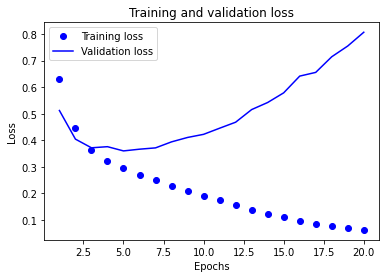

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()